<a href="https://colab.research.google.com/github/PabloDome/CosasUtilesDW/blob/main/Dominios_DispersionVelocidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import cauchy
from scipy import stats
from scipy import integrate
from numba import jit

Escala = 0.467 # Escala de las imagenes (micron/pixel)

#@jit
def ContornoPolares(coordenadas_contorno, P):
    coordenadas_contorno[:,0] = coordenadas_contorno[:,0] - P[0]
    coordenadas_contorno[:,1] = coordenadas_contorno[:,1] - P[1]

    Vector = coordenadas_contorno*1.0
    Polar = np.zeros(Vector.shape)

    for i in range(len(Vector[:,0])):
        if Vector[i,0]>0 and Vector[i,1]>=0:
            Polar[i,0] = np.arctan(Vector[i,1]/Vector[i,0])
        elif Vector[i,0]==0 and Vector[i,1]>=0:
            Polar[i,0] = np.pi/2
        elif Vector[i,0]<0:
            Polar[i,0] = np.pi +  np.arctan(Vector[i,1]/Vector[i,0])
        elif Vector[i,0]==0 and Vector[i,1]<0:
            Polar[i,0] = 3*np.pi/2
        elif Vector[i,0]>0 and Vector[i,1]<0:
            Polar[i,0] = 2*np.pi + np.arctan(Vector[i,1]/Vector[i,0])

        Polar[i,1] = Escala*np.sqrt(pow(Vector[i,0],2) + pow(Vector[i,1],2))

    columna_a_ordenar = Polar[:, 0]  # Primera columna
    indices_ordenados = np.argsort(columna_a_ordenar)
    matriz_ordenada = Polar[indices_ordenados]

    return matriz_ordenada

#@jit(nopython=True)
def PendOrd(y2,y1,x2,x1):
    PO = np.zeros(2)
    PO[0] = (y2-y1)/(x2-x1)
    PO[1] = (y1*x2-y2*x1)/(x2-x1)

    return PO


def PolarDiscreto(Polar, PuntosDiscreto):

    Polar_discreto = np.zeros((PuntosDiscreto,2))

    Tam = len(Polar[:,0])

    for i in range(PuntosDiscreto):
        Polar_discreto[i,0] = (i+1)*np.pi*2/PuntosDiscreto

        j = 0
        while j < Tam:

            if (Polar_discreto[i,0] - Polar[j,0]) < 0:
                Pend = PendOrd(Polar[j,1],Polar[j-1,1],Polar[j,0],Polar[j-1,0])
                Polar_discreto[i,1] = Pend[0]*Polar_discreto[i,0] + Pend[1]
                j = Tam

            elif (Polar_discreto[i,0] - Polar[j,0]) == 0:
                Polar_discreto[i,1] = Polar[j,1]
                j = Tam

            j = j + 1

        if Polar_discreto[i,0]<Polar[0,0]:
            Polar_discreto[i,1] = Polar[0,1]

        if (Polar_discreto[i,0] > Polar[Tam-1,0]):
            Polar_discreto[i,1] = Polar[Tam-1,1]

    return Polar_discreto

def ProcesoImagen(ImagenDominio,ImagenFondo, Vecinos, VecinosRetoque, umbral_valor, Perimetro_min, Perimetro_max, NumContorno):
    # Proceso 1 - Binarización de la imagen

    ImagenResta = -ImagenDominio+ImagenFondo
    ImagenPromedio = cv2.GaussianBlur(ImagenResta, (Vecinos*2+1,Vecinos*2+1), 0) #Promedio Gaussiano, (Imagen, Tamaño Kernel (número impares y positivos), DesviaciónEstandar en dir x)
    _, Imagen_Binaria = cv2.threshold(ImagenPromedio, umbral_valor, 255, cv2.THRESH_BINARY)


    # Proceso 2 - Limpieza de partículas

    Imagen2 = 0*Imagen_Binaria
    contornos, jerarquia = cv2.findContours(Imagen_Binaria[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    Imagen_contornos = cv2.drawContours(Imagen2.astype(np.uint8), contornos, -1, (255, 255, 255), 2)
    perimetros = [cv2.arcLength(contorno, True) for contorno in contornos]
    ContornosLimpiosPer = []
    for i in range(len(perimetros)):
        if perimetros[i]>Perimetro_min and perimetros[i]<Perimetro_max:
            ContornosLimpiosPer.append(contornos[i])

    Imagen_contornos_limpios = cv2.drawContours(Imagen2*0, ContornosLimpiosPer, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Proceso 3 - Retoque bordes y contornos
    ImagenPromedio2 = cv2.GaussianBlur(Imagen_contornos_limpios, (VecinosRetoque*2+1,VecinosRetoque*2+1), 0) #Promedio Gaussiano, (Imagen, Tamaño Kernel (número impares y positivos), DesviaciónEstandar en dir x)
    _, Imagen_Binaria2 = cv2.threshold(ImagenPromedio2, (255/2), 255, cv2.THRESH_BINARY)


    contornos, jerarquia = cv2.findContours(Imagen_Binaria2[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    Imagen_contornos = cv2.drawContours((Imagen_Binaria2*0).astype(np.uint8), contornos[NumContorno], -1, (255, 255, 255), 5)
    coordenadas_contorno = contornos[NumContorno].reshape(-1, 2) # Con esto paso los contornos a un vector

    return Imagen_Binaria2, Imagen_contornos, coordenadas_contorno


def CentroMasa(Perfil):
    Tam = len(Perfil[:,0])

    CM = np.zeros(2)

    for i in range (Tam):
        CM[0] = CM[0]+Perfil[i,0]
        CM[1] = CM[1]+Perfil[i,1]

    return CM/Tam

def FunRugosidad(Perfil):
    Tam_Perf = len(Perfil[:,1])

    Br = np.zeros((Tam_Perf, 2))

    for k in range(Tam_Perf):
        Br[k,0] = 2*np.pi*(k+1)/(Tam_Perf+1)

        sum = 0
        for j in range(Tam_Perf-k):
            sum = pow(Perfil[j+k,1]-Perfil[j,1],2) + sum

        Br[k,1] = sum/(Tam_Perf-k)

    return Br

def CalculoU2(Perfil):
    R_med = np.mean(Perfil[:,1])
    Tam = len(Perfil[:,1])
    u2 = 0

    for i in range(Tam):
        u2 = u2 + pow(Perfil[i,1],2)

    return u2/Tam


def FactorDeEstructura(Perfil):
    Tam_Perf = len(Perfil[:,1])

    Largo = integrate.simpson(Perfil[:,1], Perfil[:,0])
    R_med = np.mean(Perfil[:,1])
    u = np.zeros(Tam_Perf)
    u[:] = Perfil[:,1] - R_med

    Sq = np.zeros((Tam_Perf, 2))

    for k in range(Tam_Perf):
        q = 2*np.pi*(k+1)/Tam_Perf
        Sq[k,0] = q*Tam_Perf/(Largo)

        sum_re = 0
        sum_im = 0

        for j in range(Tam_Perf):
            sum_re = u[j]*np.cos(-(j+1)*q) + sum_re
            sum_im = -u[j]*np.sin(-(j+1)*q) + sum_im

        Sq[k,1] = ((sum_re ** 2)+(sum_im**2))/(Tam_Perf**2)

    Sq[Tam_Perf-1,1] = Sq[Tam_Perf-2,1]

    return Sq

def Autocorrelacion(Perfil):
    R_med = np.mean(Perfil[:,1])
    autocorr = np.correlate(Perfil[:,1] - R_med, Perfil[:,1] - R_med, mode='full') / np.sum((Perfil[:,1] - R_med) ** 2)
    Escala = np.pi*4/autocorr.size

    vector = [x for x in range(0, autocorr.size)]
    Theta = list(map(lambda x: x*Escala-np.pi*2, vector))

    Acorr = np.zeros((len(Theta),2))

    Acorr[:,0] = Theta
    Acorr[:,1] = autocorr

    return Acorr

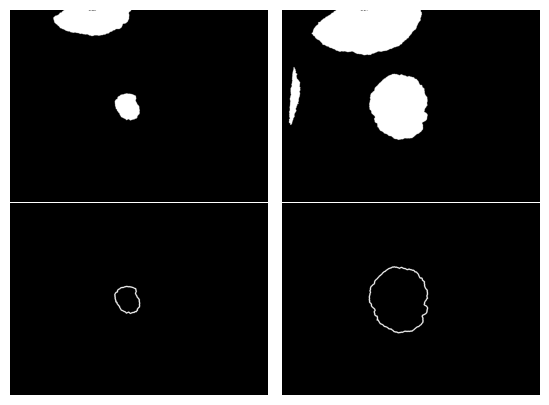

In [5]:
Vecinos = 5 # Cantidad de vecinos para el filtro gaussiano (en realidad el programa toma 2*Vecinos+1)
VecinosRetoque = 5  # Es para retocar un poco la imagen binaria, de no ser necesario poner en 0

umbral_valor = 140  # Valor umbral que se puede deteminar mediante el histograma
Perimetro_min = 100 # Filtro por perímetro mínimo
Perimetro_max = 8000 # Filtro por perímetro mínimo

umbral_valor2 = 140  # Valor umbral que se puede deteminar mediante el histograma
Perimetro_min2 = 100 # Filtro por perímetro mínimo
Perimetro_max2 = 8000 # Filtro por perímetro mínimo

#DirImagen = '/home/pablo/mnt/Users/Pablo/Desktop/Datos/Post-Doc/Muestras IEEE/MOKE - Bariloche/M1/P3/T-amb-293K/M1-BG-i=1.0-30s_1/Default'
#Dir2 = "/home/pablo/mnt/Users/Pablo/Desktop/Datos/Post-Doc/ProcesoImagenes"

NombreSat = 'Imagen-0'
NumImagen1 = 6
NumImagen2 = 10
Tiempo_entre_imag = 30/1000 #Segundos

NumContorno1 = 0
NumContorno2 = 0

Nombre1 = 'Imagen-'+str(NumImagen1)
Nombre2 = 'Imagen-'+str(NumImagen2)

ImagenFondo = cv2.imread(NombreSat+'.tif')
ImagenDominio = cv2.imread(Nombre1+'.tif')
ImagenDominio2 = cv2.imread(Nombre2+'.tif')

Imagen_Binaria, Imagen_contornos, coordenadas_contorno = ProcesoImagen(ImagenDominio,ImagenFondo, Vecinos, VecinosRetoque, umbral_valor, Perimetro_min, Perimetro_max, NumContorno1)
Imagen_Binaria2, Imagen_contornos2, coordenadas_contorno2 = ProcesoImagen(ImagenDominio2,ImagenFondo, Vecinos, VecinosRetoque, umbral_valor2, Perimetro_min2, Perimetro_max2, NumContorno2)

fig = plt.figure()
fig.set_size_inches(7, 5)
fig.subplots_adjust(hspace = 0.0, wspace = 0.005)

plt.subplot(2, 2, 1)
plt.imshow(Imagen_Binaria)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(Imagen_Binaria2)
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(Imagen_contornos)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(Imagen_contornos2)
plt.axis('off')

plt.show()

<ipython-input-3-787abc709b3f>:10: RuntimeWarning: divide by zero encountered in log
  lnBr = np.log(FunRugosidad(Polar_Elegido_discreto))


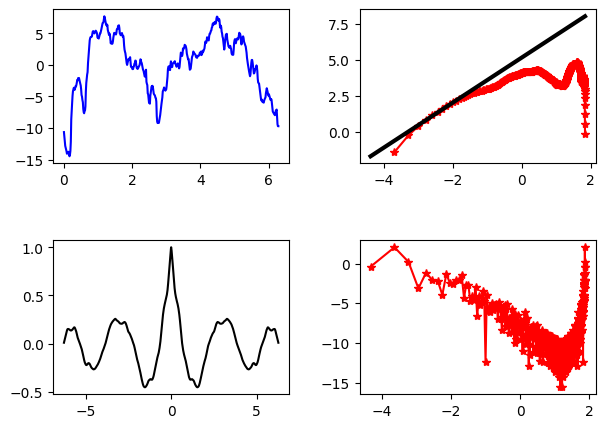

0.7831290765660562
5.135951055491081


In [3]:
#DirBr = '/home/pablo/mnt/Users/Pablo/Desktop/Datos/Post-Doc/Muestras IEEE/MOKE - Bariloche/M1/P3/T-amb-293K/AnalisisBr'

CM_Rug = CentroMasa(coordenadas_contorno2) # El inicio de coordenadas es el centro de masa del primer contorno
Polar_Elegido = ContornoPolares(coordenadas_contorno2, CM_Rug)
PuntosDiscreto = 500
Polar_Elegido_discreto = PolarDiscreto(Polar_Elegido, PuntosDiscreto)

R0 = np.mean(Polar_Elegido_discreto[:,1])

lnBr = np.log(FunRugosidad(Polar_Elegido_discreto))
lnSq = np.log(FactorDeEstructura(Polar_Elegido_discreto))
Acorr = Autocorrelacion(Polar_Elegido_discreto)
I_ini = 3 #Los puntos de ajuste para la regresión lineal de Br
I_fin = 13

slope, intercept, r_value, p_value, std_err = stats.linregress(lnBr[I_ini:I_fin,0], lnBr[I_ini:I_fin,1])

fig = plt.figure()
fig.set_size_inches(7, 5)
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

plt.subplot(2, 2, 1)
plt.plot(Polar_Elegido_discreto[:,0], Polar_Elegido_discreto[:,1]-R0, '-', color = 'b')

plt.subplot(2, 2, 2)
plt.plot(lnBr[:,0], lnBr[:,1], '*-', color = 'r')
plt.plot(lnBr[:,0], lnBr[:,0]*slope+intercept, '-', color = 'k', lw = 3)

plt.subplot(2, 2, 3)
plt.plot(Acorr[:,0], Acorr[:,1], '-', color = 'k')

plt.subplot(2, 2, 4)
plt.plot(lnSq[:,0], lnSq[:,1], '*-', color = 'r')

plt.show()

#np.savetxt('/FuncionBr-BG-1.0A-'+str(NumImagen2)+'.txt', FunRugosidad(Polar_Elegido_discreto))
#np.savetxt('/FactorSq-BG-1.0A-'+str(NumImagen2)+'.txt', FunRugosidad(Polar_Elegido_discreto))
#np.savetxt('/Autocorr-BG-1.0A-'+str(NumImagen2)+'.txt', FunRugosidad(Polar_Elegido_discreto))

print(slope/2)
print(intercept)

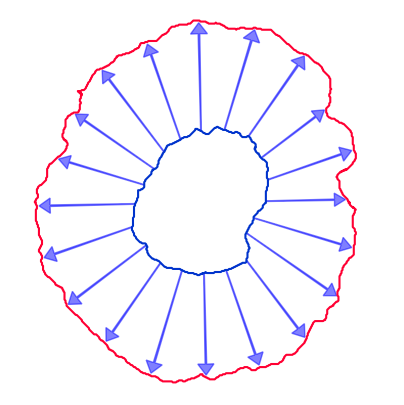

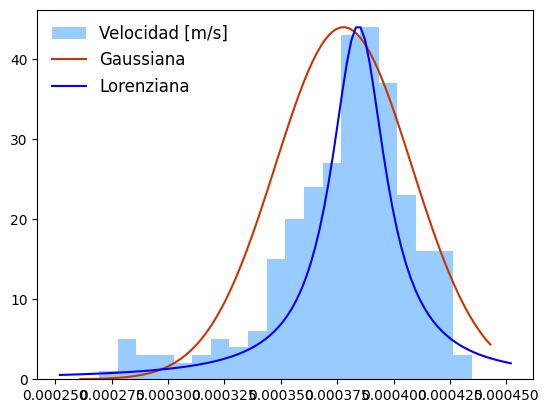

In [6]:
P = CentroMasa(coordenadas_contorno) # El inicio de coordenadas es el centro de masa del primer contorno

P_corte_ini = [300, 400]
P_corte_fin = [800, 900]

Polar = ContornoPolares(coordenadas_contorno, P)
Polar2 = ContornoPolares(coordenadas_contorno2, P)

PuntosDiscreto = 300
Polar_discreto = PolarDiscreto(Polar, PuntosDiscreto)
Polar_discreto2 = PolarDiscreto(Polar2, PuntosDiscreto)

# Paso a polares y armo el campo de velocidades

fig = plt.figure()
fig.set_size_inches(5, 5)

plt.polar(Polar[:,0],Polar[:,1], color = '#0033CC')
plt.polar(Polar2[:,0],Polar2[:,1], color = '#FF0033')

for j in range(20):
    i = round(j*PuntosDiscreto/20)
    arr1 = plt.arrow(Polar_discreto[i,0], Polar_discreto[i,1], 0, Polar_discreto2[i,1]-Polar_discreto[i,1]-6, alpha = 0.5, width = 0.01, head_length=5.0, head_width = 0.1, color = '#0000FF')

plt.axis('off')
#plt.savefig(DirImagen+'/EvolucionDominio.png')
plt.show()

# Análisis de una distribución Gaussiana, que probablemnente no sea así, parece una lorenziana

DistVelo = np.zeros(PuntosDiscreto)
DistVelo[:] = (Polar_discreto2[:,1]-Polar_discreto[:,1])*(1e-6)/((NumImagen2-NumImagen1)*Tiempo_entre_imag) #Esto ultimo es para obtener las velocidades
plt.hist(DistVelo, 20, color = '#3399FF', alpha = 0.5, label = 'Velocidad [m/s]')

conteos, bordes = np.histogram(DistVelo, bins=20)
valor_maximo = np.max(conteos)

mu, std = norm.fit(DistVelo)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p*valor_maximo/max(p), color = '#CC3300', label = 'Gaussiana')

mu, std = cauchy.fit(DistVelo)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = cauchy.pdf(x, mu, std)

plt.plot(x, p*valor_maximo/max(p), color = '#0000FF', label = 'Lorenziana')

plt.legend(loc='upper left', framealpha=0.0, fontsize = 12)
plt.show()


#cv2.imwrite(Dir2+'/Diferencia.png',Imagen_contornos[:,:,0])
#np.savetxt(DirImagen+'/Perfil-'+Nombre1+'.txt', Polar_discreto)
#np.savetxt(DirImagen+'/Perfil-'+Nombre2+'.txt', Polar_discreto)
#np.savetxt(DirImagen+'/DiferenciasVelocidad-Histograma.txt', DistVelo)